In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools

# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2018

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matemáticos para aproximar una función de valor. Al utilizar este tipo de herramientas, aumentamos el riesgo de ver un comportamiento inestable y divergente durante el entrenamiento del agente. Esto se da en presencia de tres aspectos principales, llamados 'Triada Mortal':

* Aproximación de funciones: es una forma poderosa y escalable de generalizar desde un espacio de estado mucho más grande que la memoria y los recursos computacionales (por ejemplo, aproximación de función lineal o Redes Neuronales Artificiales).

* Bootstrapping: se actualizan objetivos que son dependientes de las estimaciones existentes (por ejemplo, en los métodos de TD) en lugar de depender exclusivamente de las recompensas reales y rendimientos completos (como en los métodos MC).

* Off-Policy: Entrenamiento de un agente en base a una política diferente a la política objetivo (Por ejemplo Q-Learning).

## CartPole: Agente aleatorio
CartPole es un entorno donde un poste está unido por una unión no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanezca en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve más de 2.4 unidades desde el centro.

In [2]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementación de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Hay un gran problema con el uso de aproximadores para la función de valor $Q$. Las transiciones están muy correlacionadas. Esto reduce la varianza general de cada transición. Ya que toda la experiencia es extraída del mismo episodio (del actual). 

Imaginemos que tuviéramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

El equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en memoria y después de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria de experiencia.

In [3]:
from agents.cart_pole_approx_vf import CartPole_SGD

agent = CartPole_SGD.SGDCartPoleSolver()
scores_SGD = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 9.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 20.82 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 15.85 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 15.05 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 13.16 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 13.36 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 12.67 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 12.25 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 12.75 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 11.05 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 12.14 ticks.


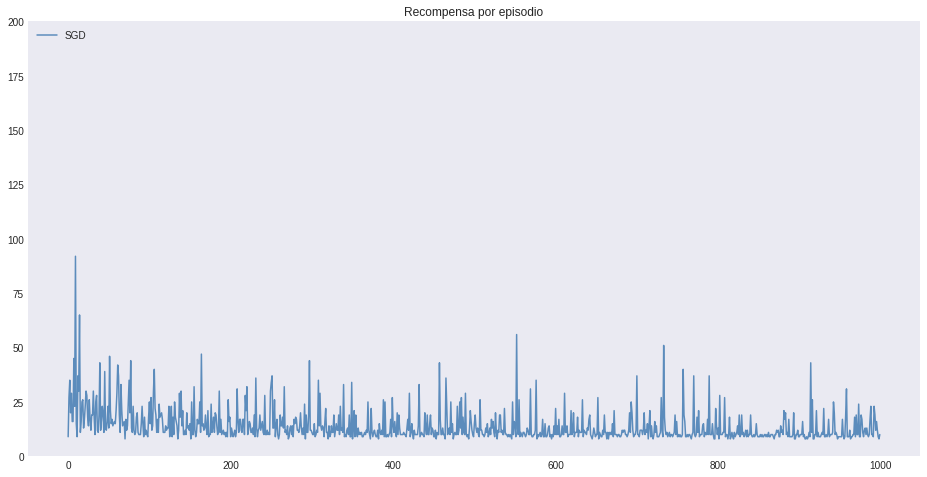

In [17]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

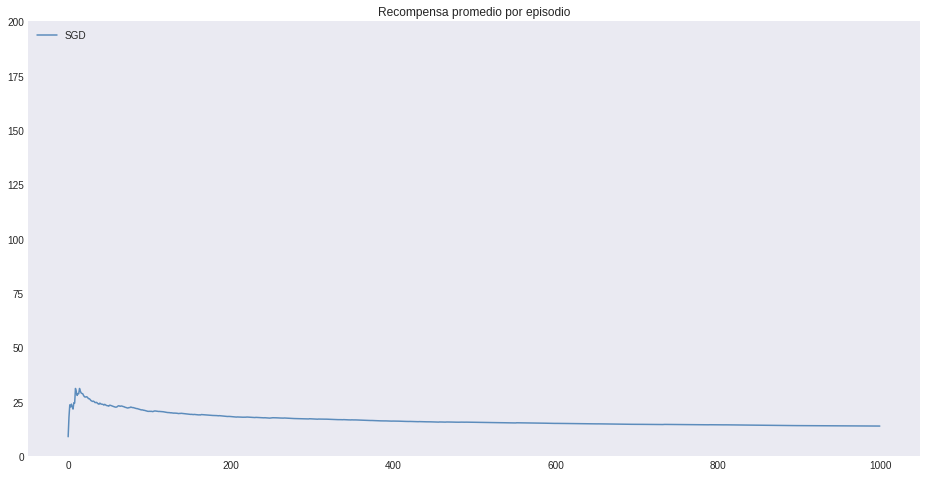

In [18]:
# se suaviza la curva de convergencia
def avg_reward(scores):
    episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
    acumulated_rewards = np.cumsum(scores)
    return [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

reward_per_episode_SGD = avg_reward(scores_SGD)

plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo tiene estados con dos dimensiones numéricas, donde para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$.

Si bien es posible elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$; no obstante, no se puede tener en cuenta ninguna interacción entre estas dimensiones. 

Además, si tanto $s_1$ como $s_2$ son $0$, entonces el valor aproximado también será $0$, es decir $x(s)=0$. Ambas limitaciones se pueden superar representando $s$ por el vector de features polinómico $x(s)=(1,s_1,s_2,s_1s_2)$. El $1$ inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s_1 s_2$, permite que se tengan en cuenta dichas interacciones.

También se podría utilizar un vector de features polinómico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciones más complejas.

In [6]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly

agent = CartPole_SGD_Poly.SGDPolyCartPoleSolver()
scores_SGD_Poly = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 16.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.53 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 21.36 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 19.89 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 19.89 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 25.34 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 22.91 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 39.49 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 42.98 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 54.03 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 74.87 ticks.


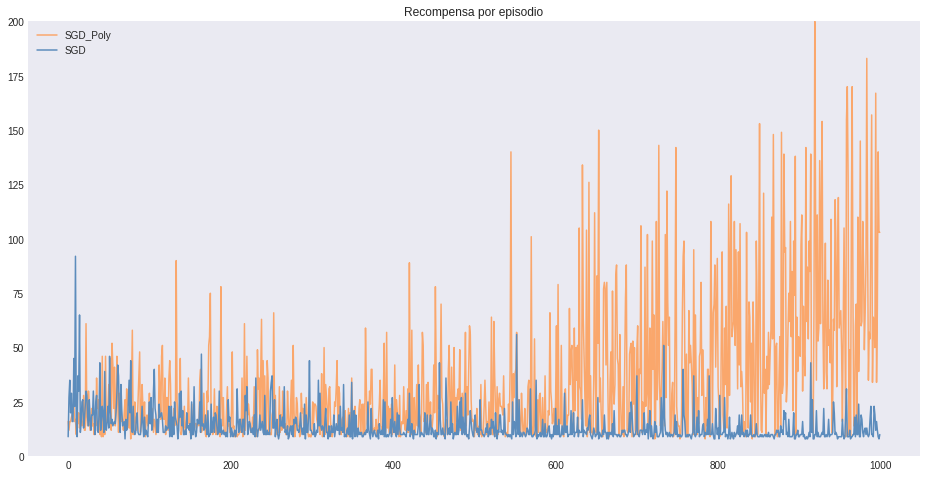

In [19]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

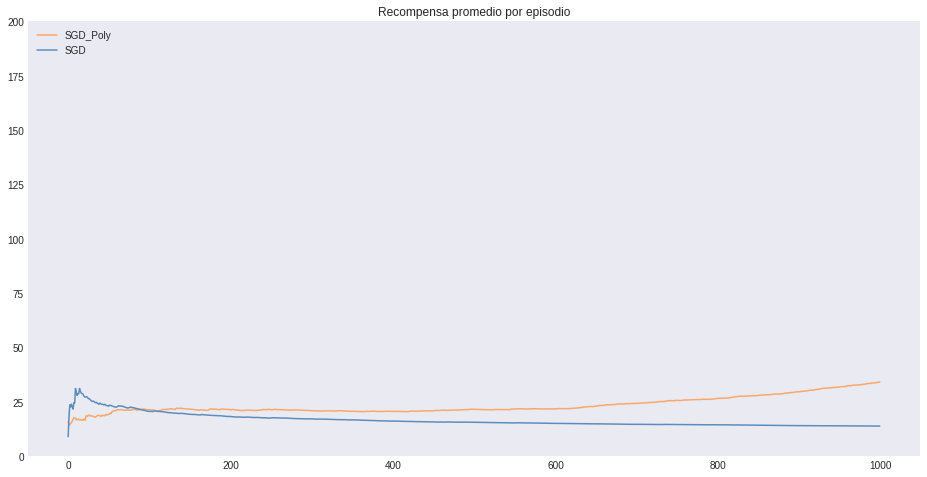

In [20]:
reward_per_episode_SGD_Poly = avg_reward(scores_SGD_Poly)

plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación actual ($w_{t}$). Donde el objetivo ($w_{t+1}$), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_{t}$ complica el proceso en comparación con la situación más simple de aprendizaje supervisado, en la que los objetivos no dependen de los parámetros que se actualizan. Esto puede conducir a oscilaciones y/o divergencia.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solución para acercar el proceso de actualización de los parámetros ($w_t$) de un estimador, al caso mas simple utilizado en aprendizaje supervisado. Esto es, cada vez que se realizan un cierto número, $C$, de actualizaciones de los pesos $w$ en el predictor, se realiza una copia de los mismos en otro modelo (Modelo Duplicado o *Dual Model*), donde se mantienen estos pesos duplicados de forma fija para las próximas $C$ actualizaciones de $w$. Las estimaciones de este modelo duplicado, se utilizan como objetivo en la actualización de los pesos $w$, en las próximas $C$ actualizaciones:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [29]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly_Dual

agent = CartPole_SGD_Poly_Dual.SGDPolyDualCartPoleSolver()
scores_SGD_Poly_Dual = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 21.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 22.79 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 29.78 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 36.59 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 101.37 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 151.15 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 108.08 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 90.09 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 89.23 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 83.19 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 83.58 ticks.


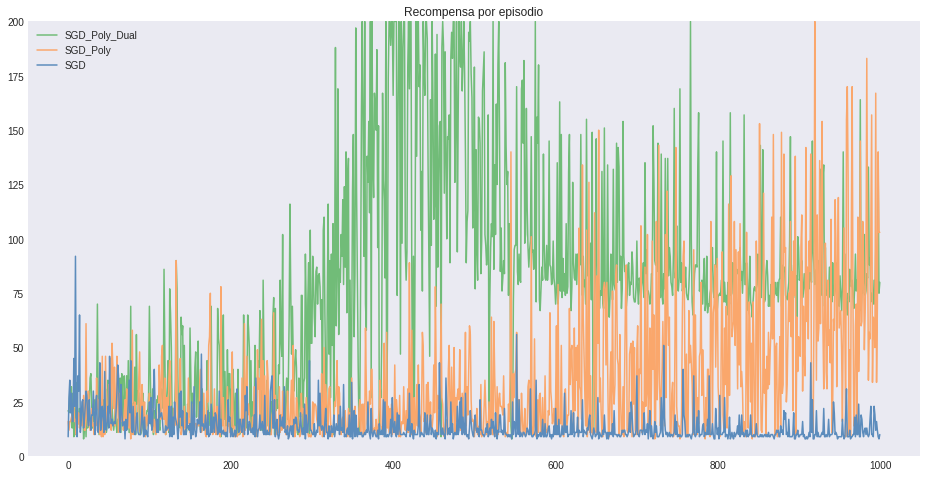

In [30]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

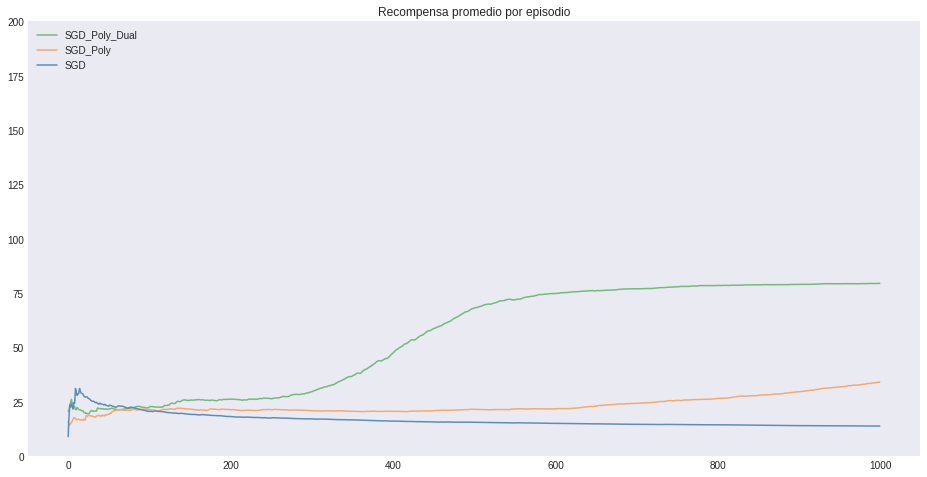

In [31]:
reward_per_episode_SGD_Poly_Dual = avg_reward(scores_SGD_Poly_Dual)
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales
Como ultima mejora, vamos a reemplazar el aproximador lineal por una red neuronal. Para el caso del CartPole, estamos trabajando con un entorno donde el agente percibe directamente los features que representan el estado del mismo. En otras palabras, como nuestro agente no percibe el estado del entorno a través de una sucesión de imágenes, no es necesario que nuestra red cuente con capas convolucionales que generen features del entorno. Por lo tanto, utilizaremos una red neuronal 'fully connected' de 3 capas con la siguiente arquitectura:

![nn_dense](images/nn_dense.png)

En este caso, como el aproximador usado es 'no lineal', no tenemos necesidad de hacer un pre-prosesamiento de los features, como en el caso del agente 'SGD_Poly' y 'SGD_Poly_Dual', para poder capturar las relaciones no lineales entre los distintos features del entorno.

### Funciones de activación:
![activation_functions](images/activation_functions.png)

In [26]:
from agents.cart_pole_approx_vf import CartPole_DQN

agent = CartPole_DQN.DQNCartPoleSolver()
scores_DQN = agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[Episode 0] - Mean survival time over last 100 episodes was 22.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 37.81 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 68.97 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 107.21 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 145.68 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 168.04 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 181.08 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 189.75 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 192.75 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 194.31 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 195.09 ticks.


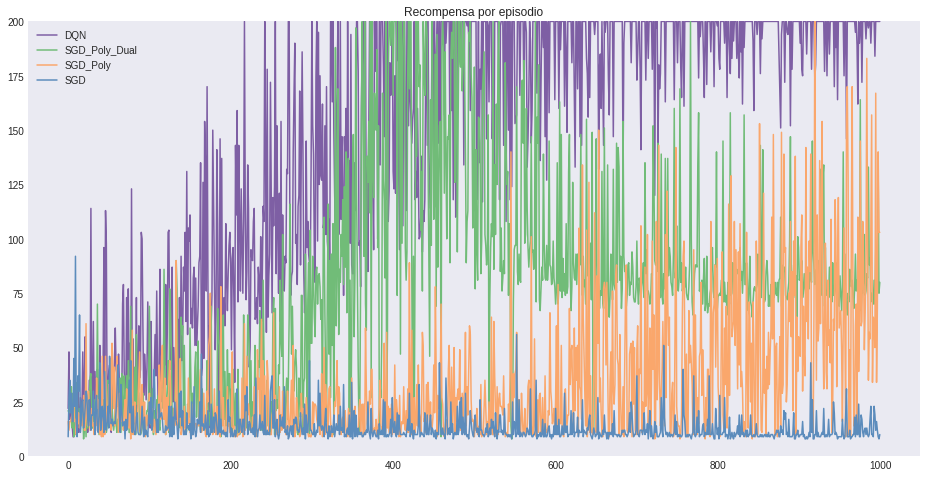

In [32]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DQN))), np.array(scores_DQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

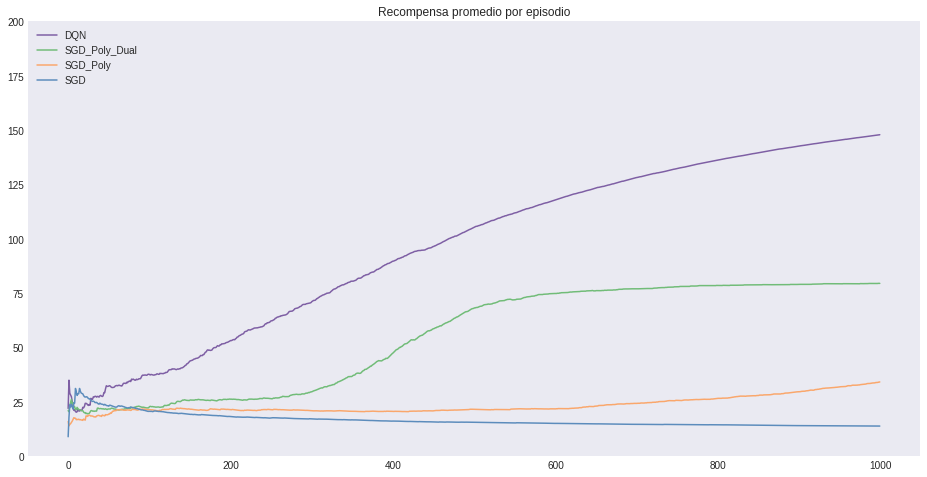

In [33]:
reward_per_episode_DQN = avg_reward(scores_DQN)
plt.plot(reward_per_episode_DQN, label='DQN', c='#7e5fa4')
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Ejercicios Lab Final

Se pide:

1) Dado el agente que utiliza una red neuronal para aproximar la función de valor, modificar la arquitectura de la misma en busca de una mejora en el desempeño del agente. La modificaciones a realizar puede ser:
    * Agregar mas capas ocultas a la red
    * Modificar las funciones de activación de las neuronas
    * Modificar el numero de neuronas en cada capa
    
**Recomendación #1**: Tener en cuenta que al incorporar mas capas y neuronas a una red neuronal, mas complejidad computacional se incorpora al modelo, lo que se traduce en una mayor duración (en tiempo) del entrenamiento del agente.

**Recomendación #2**: Una métrica eficiente para comparar del desempeño de diferentes agentes es la curva de "reward promedio acumulado". Esta métrica permite visualizar el desempeño general del agente, como así también la rapidez (cantidad de episodios) que requiere un agente para alcanzar un determinado desempeño. 

**Recomendación #3**: Al modificar distintos aspecto de la arquitectura del aproximador, realizar de a un cambio por evaluación.

2) Adaptar los agentes implementados en el notebook (incluido el implementado por ustedes) al entorno 'MountainCar-v0' (http://gym.openai.com/envs/MountainCar-v0/) y comparar el desempeño de los mismos.

3) Elaborar un informe que enumere lo realizado paso a paso, mostrando resultados parciales y finales. 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo Pycharm, debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.